In [16]:
"""
Anqi (Amy) Feng, Feb25

"""
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import numpy.linalg as la
import matplotlib.pyplot as plt
from collections import OrderedDict


In [17]:
# train multi-layer perceptron
class MLPipeline:
    def __init__(self, epochs=250, lr=0.025):
        self.epochs = epochs
        self.lr = lr

    def gen_data(self,):
        raise NotImplementedError

    def loss(self,):
        raise NotImplementedError

    def forward(self,):
        raise NotImplementedError

    def backward(self,):
        raise NotImplementedError

    def update(self,):
        raise NotImplementedError

    def metrics(self,x,y):
        raise NotImplementedError

    def fit(self, x_data, y_data, x_eval, y_eval, printing=False):
        if printing:
            self.x_eval = x_eval
            self.y_eval = y_eval
        for epoch in range(self.epochs):
            y_pred = self.forward(x_data)
            loss = self.loss(y_pred, y_data)
            grad = self.backward(x_data, y_data)
            self.update(grad)
            if printing:
                m = self.metrics(x_eval, y_eval)
                if epoch % 100 == 0:
                    print(f"epoch {epoch} and train loss {loss.mean():.2f}, test metrics {m:.2f}")
        if printing:
            self.m = m


class FCNetTo(MLPipeline):
    def __init__(self, params:list=None, dims:list=None, epoch:int= 250, lr=0.05):
        super().__init__(epochs=epoch, lr=lr)
        if dims is not None:
            self.dims = dims
        elif params is not None:
            weights = params[0]
            bias = params[1]
            dims = [weights[0].shape[0]]
            for w in weights:
                dims.append(w.shape[1])  # list [1, 5, 3, 5, 1]
        od = OrderedDict()
        self.activation = nn.Sigmoid()
        for j in range(len(dims)-1):
            od[f"linear_{j}"] = nn.Linear(dims[j], dims[j+1])
            if params is not None:
                w = np.transpose(weights[j])
                b = bias[j]
                od[f"linear_{j}"].weight = nn.Parameter(torch.tensor(w, requires_grad=True).float())
                od[f"linear_{j}"].bias = nn.Parameter(torch.tensor(b, requires_grad=True).float())
            od[f"activation_{j}"] = self.activation

        self.forward_stack = nn.Sequential(od)

    def forward(self, x):
        x = torch.transpose(torch.tensor(x), 0, 1).float()  # torch tensor (350, 1)
        return self.forward_stack(x)


class FCNetFS(MLPipeline):
    def __init__(self,params:list=None, dims:list=None, epochs:int = 1500, lr = .01):
        super().__init__(epochs = epochs,lr = lr)
        if params is None:
            weights = []
            bias = []
            for j in range(int(len(dims)-1)):
                w = 10 * (np.random.random([dims[j], dims[j+1]])-.5)
                b = 10 * (np.random.random(dims[j+1]) - .5)
                weights.append(w)
                bias.append(b)
        else:
            weights = params[0]
            bias = params[1]
            dims = [weights[0].shape[0]]
            for w in weights:
                dims.append(w.shape[1])

        self.weights = weights
        self.bias = bias
        self.dims = dims
        self.n_layers = len(dims)

    def forward(self, x):
        la = self.full_forward(x)  # list[(350,1), (350,5), (350,3), (350, 5), (350,1)]
        a = la[-1]
        return a  # ndarray (350, 1)

    def full_forward(self, x):
        assert x.shape[0] == self.dims[0], "Incorrect input dimension!"
        j = 0
        a = x.transpose()
        layer_acts = [a]
        for weight in self.weights:
            z_pre = a @ weight  # Previous: weight ndarray(1,5)  a ndarray(1,350) --> a.transpose * weight
            z = z_pre + self.bias[j]
            if j < self.n_layers - 1:
                a = self.activation(z)
            else:
                a = z
            layer_acts.append(a)
            j+=1
        return layer_acts

    def backward(self, x_in, y_truth):
        return None

    def update(self,grad):
        return None


    def metrics(self,x,y):
        return None

    def activation(self,z):
        return self.sigmoid(z)

    def sigmoid(self,z):
        return 1/(1+np.exp(-z))

    def loss(self, x_in, y_truth):
        ### calculating loss using partial as initial computation
        return None

    def l_grad(self,x_in,y_truth):
        ### partial loss / partial y_pred
        return None

In [18]:
#Step 0: Initialize a 4-layers network Onet as well as its parameters, including bias and weights
onet = FCNetFS(dims=[1, 2, 3, 1], epochs=1500, lr=.01)  #ndim 1-> 2 ->3 -> 1
onet.weights
onet.bias
onet.dims

[1, 2, 3, 1]

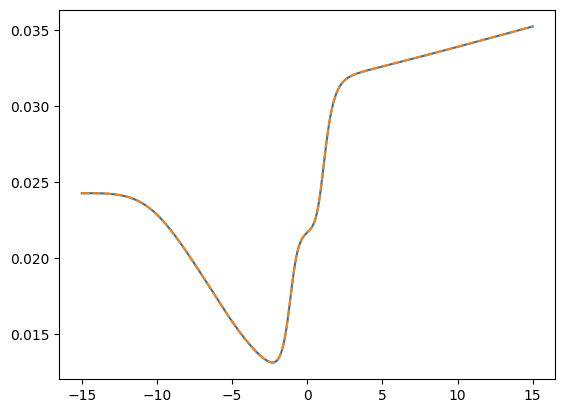

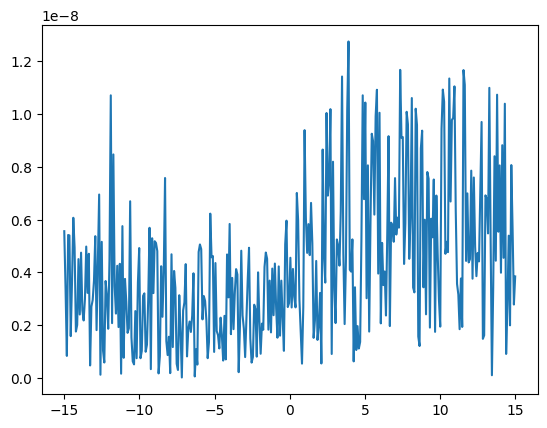

In [19]:
 # #Step 1:  Initialize a 5-layers "From Scratch" network Anet,
# use the same parameters to initialize Torch Network Bnet
anet = FCNetFS(dims=[1, 5, 3, 5, 1], epochs=250, lr=0.01)
bnet = FCNetTo(params=[anet.weights, anet.bias])
# Before continuing, examine your bnet.forward_stack to ensure that layers are coordinated as you
n_samp = 350
tspace = np.linspace(-15, 15, n_samp).reshape(1, 350)  # ndarray (350,) --> (1,350)
y1 = anet.forward(tspace)
y2 = bnet.forward(tspace)

#Step 1.5 sanity check: can you reproduce From Scratch network with prespecified weights params?
a2net = FCNetFS(params=[anet.weights, anet.bias])
y3 = a2net.forward(tspace)
plt.figure(1)
plt.plot(tspace.flatten(),y1.flatten())
plt.plot(tspace.flatten(),y2.detach().numpy(),'--')
plt.figure(2)
plt.plot(tspace.flatten(),np.abs(y1.flatten()-y2.detach().numpy().flatten())+np.abs(y1.flatten()-y3.flatten()))
plt.show()

/var/folders/4w/mnp4894d3y57fd9mwr2p7hhh0000gq/T/ipykernel_6928/573213344.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.transpose(torch.tensor(x), 0, 1).float()  # torch tensor (350, 1)


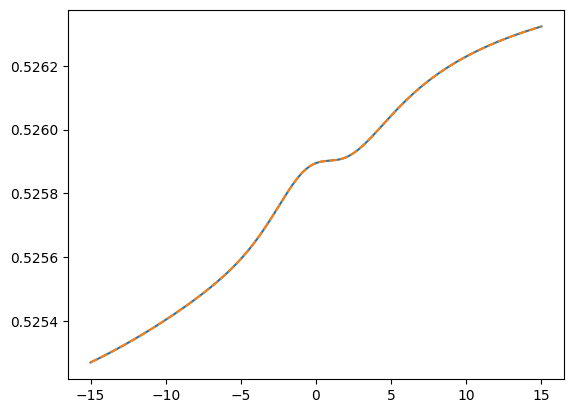

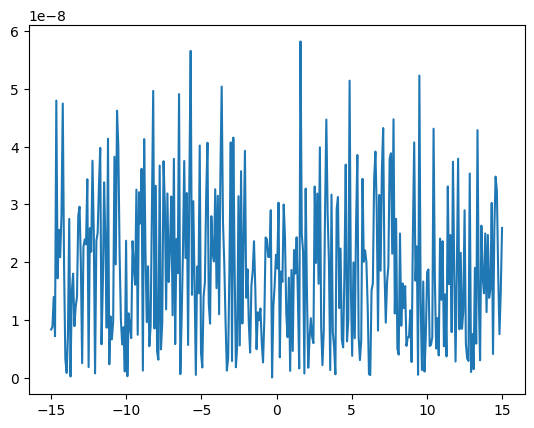

In [20]:
 # Step 2: Generate "To[rch]" Network and Instantiate from scratch network with these weights
cnet = FCNetTo(dims=[1, 7, 5, 7, 1])
weights = []
bias = []
for layer in cnet.forward_stack:
    if isinstance(layer, nn.Linear):
        weights.append(np.transpose(layer.weight.detach().cpu().numpy()))
        bias.append(np.transpose(layer.bias.detach().cpu().numpy()))
params = [weights, bias]
dnet = FCNetFS(params)
y3 = cnet.forward(torch.tensor(tspace).float())
y4 = dnet.forward(tspace)
plt.figure(3)
plt.plot(tspace.flatten(), y4.flatten())
plt.plot(tspace.flatten(), y3.detach().numpy(), '--')
plt.figure(4)
plt.plot(tspace.flatten(), np.abs(y4.flatten() - y3.detach().numpy().flatten()))
plt.show()